In [1]:
# Copyright 2011-2018 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

import numpy as np
from scipy.optimize import newton, brentq, minimize_scalar
from _boundstate_hermitian import eig_values, false_positive_BS, eig_val_derivative
from _boundstate_svd import singular_values
from _boundstate_common import *

__all__ = ['bound_state', 'wf_in_leads']

def bound_state(syst, E_range, args=(), params=None, tol=1e-8, sparse=False, 
                return_wf=False, maxiter=100, eig_val=2, need_orth=True):
    """Find a single bound state in the energy window '(emin, emax)'.

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have at least one lead attached. If you need to find bound
        states of a finite system, use an eigensolver.
    emin, emax : float
        The energy bounds in which to search for bound states.
    E_0: starting point of the newton method
    args : tuple
        Positional arguments to the system.
    params : dict
        Keyword arguments to the system.
    eps : float
        Tolerance with which to find the bound state.
    return_wavefunction : bool
        Whether or not to return the bound state wavefunction.
    maxiter: maximum number of steps used by the newton method
    eig_val: the number of eigenvalue to be computed. Only if sparse 
             is True
    need_orth: Whether to orthogonalize the leads modes. Only necessary 
               for degenerate eigenmodes

    Returns
    -------
    E: energy of the bound state
    if return _wf is True:
        psi_alpha_0: wavefunction in the scattering region
        lmb: Evanescent modes in the lead at a given energy
        q_e: 
        Phi: 
    elements fo compute the wavefunction in the leads

    Notes
    -----
    TODO: finish this docstring
    Can use Newton method to find the root. Downside of this method: 
    -needs a good initial guess (i.e. first Taylor expansion term bigger
     than others) 
    -assume that the minimal eigenvalue is a smooth function, which is 
     not the case when a mode opens in the lead, or when the minimal 
     eigenvalue changes
    Upside: Fast
    Brentq:
    from scipy, "Generally considered the best of the rootfinding routines here"

    Returns at most 1 bound state...
    """
    mat = extract_kwant_matrices(syst, sparse=sparse, args=args, params=params)
    #print(mat)
    # To use Singular value decomposition and look for a minimum
    return SVD_formulation(mat, E_range, tol, return_wf=return_wf, sparse=sparse)
    # To use eigenvalue decomposition and look for a root
    # return Hermitian_formulation(mat, E_0, return_wf=return_wf)

def SVD_formulation(mat, E_range, tol, return_wf=False, sparse=False, sigma=None, sing_values=1):
    """
    Compute the singular values of Eq.11
    """
    def min_sing(e):
        return min(singular_values(*mat, e, sparse=sparse, uv=False, sing_values=1))

    minimum = minimize_scalar(min_sing, method='Bounded', bounds=E_range, 
                              options={'xatol': tol})
    if minimum.fun > 1e-5:
        print(minimum)
        print(minimum.fun)
        return None

    E = minimum.x
    #print(E)
    if return_wf:
        S, Wh, L_out, X_out = singular_values(*mat, E, sparse=sparse,
                                              uv=True, sigma=sigma,
                                              sing_values=sing_values)
        psi_alpha_0, q_e, L_out, Phi = compute_wf(S, Wh.conj().T, L_out, 
                                                X_out, mat[0].shape[0], 
                                                tol=1e-5,schur_modes=False)
        return E, psi_alpha_0, q_e, L_out, Phi
    else:
        return E

def Hermitian_formulation(mat, E_0, return_wf=False, fprime=eig_val_derivative):

    def min_eig(e, *mat, sparse=sparse):
        eig = eig_values(*mat, e, sparse=sparse, uv=False, sing_values=1)
        idx = np.argmin(abs(eig))
        return eig[idx]

    try:
        E = newton(min_eig, E_0, fprime=fprime, tol=tol, args=(*mat, sparse))

        if not false_positive_BS(*mat, E, eps=eps):
            print('False positive, no bound state')
            return None
        if return_wf:
            S, Wh, L_out, X_out = eig_values(*mat, E, sparse=sparse,
                                             uv=True)
            psi_alpha_0, q_e, L_out, Phi = compute_wf(S, Wh.conj().T, L_out, 
                                                X_out, mat[0].shape, 
                                                tol=tol,schur_modes=False)
            return E, psi_alpha_0, q_e, L_out, Phi
        else:
            return E

    except RuntimeError:
        print('no bound states found')

def wf_in_leads(q_e, L_out, Phi, j):
    """
    Compute the bound state wavefunction in the jth cell of the lead.
    According to M.W. notes, the first unit cell is labbelled by 1.
    Eq.7 in the paper
    """
    return Phi @ np.linalg.matrix_power(L_out, j) @ q_e 


# Example

In [2]:
import kwant
import tinyarray
import numpy as np
import scipy as spi
import scipy.constants as const
import scipy.signal as signal

import matplotlib.pyplot as plt 
import matplotlib.colors as colors
print(const.e)

1.602176634e-19


In [3]:
a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
t = (const.hbar**2.)/(2.*0.023*const.m_e*(a*1e-10)**2.)/const.e*1000.
print(t)

4513.29322846401


In [4]:
## realistic parameters InAs with Al shell
# Energy unit: meV, length unit: A

def make_system_real(L=1000., a=6.0583, m=0.023, alpha=100., mu=0., U_0=0., delta=0.1, B=0.2, phi=0., salt='chizhang'):
    #a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
    W = int(np.round(L/a))
    t = (const.hbar**2.)/(2.*m*const.m_e*(a*1e-10)**2.)/const.e*1000.
    nu = alpha/a #https://arxiv.org/pdf/1205.1550.pdf
    print('Parameters: W, t, nu, mu, U_0, delta, B, phi, salt')
    print([W, t, nu, mu, U_0, delta, B, phi, salt])
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define onsite and hopping ####
    def onsite(site):
        return (2.*t-mu-U_0*kwant.digest.gauss(repr(site), repr(salt)))*tau_z + B*tau_z@sigma_x
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = onsite
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    #### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [5]:
## realistic parameters InAs with Al shell
# Energy unit: meV, length unit: A
#g = 14.7 #https://doi.org/10.1016/0375-9601(67)90541-5

def make_system_mixed(L_A=3700., W=1400., a=6.0583, m=0.023, alpha=350., mu=0., U_0=0., delta=0.182, B=0., phi=0., g=14.7, salt='chizhang', eta=None):
    
    #a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
    L = int(np.round(L_A/a))
    t = (const.hbar**2.)/(2.*m*const.m_e*(a*1e-10)**2.)/const.e*1000.
    E_plus = (6.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    E_minus = (-2.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    if eta is None:
        eta = np.sqrt(2)*alpha/W
    else:
        eta = eta
    nu = alpha/(2.*a)
    #B = g*mu_B*B_Tesla/2./const.e*1000.
    print('Parameters: L, t, E_plus, E_minus, eta, nu, B')
    print([L, t, E_plus, E_minus, eta, nu, B])
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    t_x = np.kron(np.kron(np.array([[0, 1], [1, 0]]), np.eye(2)), np.eye(2)) # e-h subspace
    t_y = np.kron(np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2)), np.eye(2))
    t_z = np.kron(np.kron(np.array([[1, 0], [0, -1]]), np.eye(2)), np.eye(2))
    sigma_x = np.kron(np.kron(np.eye(2), np.array([[0, 1], [1, 0]])), np.eye(2)) # subband subspace
    sigma_y = np.kron(np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]])), np.eye(2))
    sigma_z = np.kron(np.kron(np.eye(2), np.array([[1, 0], [0, -1]])), np.eye(2))
    s_x = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, 1], [1, 0]])) # spin subspace
    s_y = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, -1j], [1j, 0]]))
    s_z = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[1, 0], [0, -1]]))
    
    #### Define onsite and hopping ####
    '''def onsite(site):
        return (2.*t-mu-U_0*kwant.digest.gauss(repr(site), repr(salt)))*tau_z + B*tau_z@sigma_x'''
    
    #### Define the scattering region. ####
    ham = (2.*t+E_plus-mu)*t_z + E_minus*sigma_z@t_z + eta*s_x@sigma_y@t_z + B*s_x
    hop = -t*t_z + 1j*nu*s_y@t_z
    #ham_scl = delta*(np.cos(-phi/2.)*t_x@s_y@sigma_y - np.sin(-phi/2.)*t_y@s_y@sigma_y)
    #ham_scr = delta*(np.cos(phi/2.)*t_x@s_y@sigma_y - np.sin(phi/2.)*t_y@s_y@sigma_y)
    ham_scl = delta*(np.cos(0.)*t_x - np.sin(0.)*t_y)
    ham_scr = delta*(np.cos(phi)*t_x - np.sin(phi)*t_y)
    #ham_scl = delta*spi.linalg.expm(-1j*phi*t_z/2.)@t_y@s_y
    #ham_scr = delta*spi.linalg.expm(1j*phi*t_z/2.)@t_y@s_y
    
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(int(np.round(L/2.))))] = ham-U_0*t_z
    syst[((lat(x), lat(x+1)) for x in range(0, L-1))] = hop
    
    '''#### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')'''
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = ham+ham_scl
    lead0[lat.neighbors()] = hop
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  ham+ham_scr
    lead1[lat.neighbors()] = hop

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[17, 45.13293228464011, 1.6506280639783437, 0.2, 0.0, 0.1, 0.0, 0.0, 'chizhang']
Spectral gap:
0.1000000173971701
Fermi momentum
0.03939557187601572
Fermi wavelength:
159.48963317384485
(array([48210, 49373, 50627, 51790]),)
[[0.10000022 0.10000002 0.10000002 0.10000022]]
[0.11246902 0.03939557 0.03939557 0.11246902]


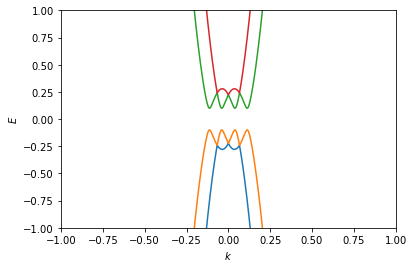

In [6]:
syst = make_system_real(B=0., a=60.583, mu=0.2)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,100001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
plt.xlabel(r'$k$')
plt.ylabel(r'$E$')
gap_energy = np.min(en[:,2])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
#plt.savefig('./Real params/dispersion a~60', dpi=300)

print('Spectral gap:')
print(np.min(en[:,2]))
print('Fermi momentum')
k_F = np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,2])])
print(k_F)
print('Fermi wavelength:')
print(2.*np.pi/k_F)
# Fermi wavelength comparable to junction length

#try the scipy function
local_minima = signal.argrelextrema(en[:,2], np.less)
print(local_minima)
print(en[local_minima, 2])
print(np.abs(np.linspace(-np.pi,np.pi,100001)[local_minima]))

In [7]:
syst = make_system_real(L=1000, a=60.583, B=0.01, mu=0., U_0=0., phi=0., salt='chizhang')
syst.hamiltonian_submatrix()
syst.leads[1].cell_hamiltonian()
syst.leads[1].inter_cell_hopping()

Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[17, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.01, 0.0, 'chizhang']


array([[-45.13293228+0.j,  -1.65062806+0.j,  -0.        +0.j,
         -0.        +0.j],
       [  1.65062806+0.j, -45.13293228+0.j,  -0.        +0.j,
         -0.        +0.j],
       [ -0.        +0.j,  -0.        +0.j,  45.13293228+0.j,
          1.65062806+0.j],
       [ -0.        +0.j,  -0.        +0.j,  -1.65062806+0.j,
         45.13293228+0.j]])

In [8]:
syst = make_system_mixed(L_A=100., W=100., a=6.0583, alpha=350., U_0=0., mu=132.3363682761002+0.2, delta=0.182, B=0.05, phi=0., eta=0.)
#L_A=3700., W=1400., a=6.0583*10, m=0.023, alpha=350., mu=0.887, U_0=0., delta=0.182, B=0., g=14.7, salt='chizhang', eta=None
E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, [-0.13253906, -0.13253906], return_wf=True)
print(E)
print(psi_alpha_0)
print(q_e)
print(L_out)
print(Phi)
#print(bound_state(syst, [-0.182, 0.], return_wf=True))
#print(bound_state(syst, [-1., 0.], return_wf=True))

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
-0.13253906
[[ 1.14931782e-02-0.00000000e+00j]
 [ 1.38544295e-02+4.00106930e-13j]
 [ 4.95951101e-17-5.53812274e-18j]
 [ 2.20260636e-16+3.47614786e-17j]
 [-1.02636181e-02-3.05806548e-12j]
 [-1.23207696e-02-1.21966115e-12j]
 [ 2.53810269e-16-2.46812139e-18j]
 [-5.54298289e-17-2.68624766e-17j]
 [ 1.16511147e-02-3.64242424e-14j]
 [ 1.37177683e-02+4.12734177e-13j]
 [ 4.74070905e-17-1.65426045e-17j]
 [ 2.46516871e-16+3.18990936e-17j]
 [-1.04077349e-02-3.05329788e-12j]
 [-1.22088011e-02-1.21508965e-12j]
 [ 2.70585086e-16+4.89574912e-18j]
 [-1.16694377e-17-2.57082574e-17j]
 [ 1.18077468e-02-7.13624337e-14j]
 [ 1.35795792e-02+4.27370788e-13j]
 [ 5.57944989e-17-2.58886117e-17j]
 [ 2.73502445e-16+2.72792621e-17j]
 [-1.05499274e-02-3.04717580e-12j]
 [-1.20944851e-02-1.20913457e-12j]
 [ 2.78607824e-16+6.21821293e-18j]
 [-5.83471883e-18-1.98991912e-17j]
 [ 1.196

In [9]:
syst = make_system_real(L=1000, a=60.583, B=0.0, mu=0., U_0=0., phi=0., salt='chizhang')
E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, [-0.08, 0.07], return_wf=True)
print(E)
print(psi_alpha_0.shape)
print(q_e.shape)
print(L_out)
print(Phi)

Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[17, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.0, 0.0, 'chizhang']
-0.07585154991328324
(76, 2)
(8, 2)
[[0.97947438+0.0757609j  0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.97947438-0.0757609j  0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.98239182+0.00401038j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.98239182-0.00401038j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.97947438+0.0757609j  0.        +0.

In [68]:
def explicit_diagonalisation(syst, en):
    ham = syst.leads[0].cell_hamiltonian()
    hop = syst.leads[0].inter_cell_hopping()
    #print(ham)
    #print(hop)
    A = np.block([[ham-en*np.identity(ham.shape[0]), hop.T.conj()], [np.identity(ham.shape[0]), np.zeros(ham.shape)]])
    B = np.block([[-hop, np.zeros(ham.shape)], [np.zeros(ham.shape), np.identity(ham.shape[0])]])
    print(A.shape)
    eigvals, eigvecs = spi.linalg.eig(A, b=B)
    lambdas = 1./eigvals
    print('lambdas')
    print(lambdas)
    print('size of lambdas')
    print(np.abs(lambdas))
    print('phase of lambdas')
    print(np.angle(lambdas))
    print('eigenvectors')
    print(eigvecs)
    print('small validation')
    print(eigvecs[0:4]/eigvecs[4:8])
    return lambdas, eigvecs

In [73]:
scipy_lambdas, scipy_vecs = explicit_diagonalisation(syst, E)
compare_lmbs = scipy_lambdas[scipy_lambdas<1.]
compare_vecs = scipy_vecs[0:4, scipy_lambdas<1.]
compare_vecs

(8, 8)
lambdas
[0.97770983-0.07643295j 1.01658558-0.07947208j 0.97770983+0.07643295j
 1.01658558+0.07947208j 0.98087164-0.00329555j 0.98087164+0.00329555j
 1.01948988-0.0034253j  1.01948988+0.0034253j ]
size of lambdas
[0.98069287 1.01968723 0.98069287 1.01968723 0.98087718 0.98087718
 1.01949563 1.01949563]
phase of lambdas
[-0.07801682 -0.07801682  0.07801682  0.07801682 -0.00335981  0.00335981
 -0.00335981  0.00335981]
eigenvectors
[[ 0.11555691-0.33973287j -0.34067801+0.07266965j -0.18182127+0.30937493j
   0.27751291-0.21054447j  0.34646885-0.19216895j -0.19207325+0.34652191j
  -0.27696165-0.18268503j  0.18260853+0.2770121j ]
 [ 0.33347372+0.12232125j -0.065237  -0.34582008j  0.31041016+0.17266367j
  -0.21929252-0.27524205j  0.13155369-0.3116236j  -0.31158725+0.13163975j
  -0.38731699+0.03176658j -0.03187356+0.3873082j ]
 [-0.31702144+0.17235837j -0.19619992+0.28519904j -0.07650019-0.3526439j
   0.34411393+0.03766304j  0.15747972+0.10463638j  0.10467987+0.15745082j
   0.42744226+0.

array([[ 0.11555691-0.33973287j, -0.18182127+0.30937493j,
         0.34646885-0.19216895j, -0.19207325+0.34652191j],
       [ 0.33347372+0.12232125j,  0.31041016+0.17266367j,
         0.13155369-0.3116236j , -0.31158725+0.13163975j],
       [-0.31702144+0.17235837j, -0.07650019-0.3526439j ,
         0.15747972+0.10463638j,  0.10467987+0.15745082j],
       [-0.15707811-0.31610785j, -0.34197329+0.08747557j,
         0.30019645-0.33526268j, -0.33517975+0.30028904j]])

In [91]:
Phi[:4, :4][:,3]/compare_vecs[:,3]

array([1.39970064-0.05438898j, 1.39970064-0.05438898j,
       1.39970064-0.05438898j, 1.39970064-0.05438898j])

In [75]:
compare_vecs

array([[ 0.11555691-0.33973287j, -0.18182127+0.30937493j,
         0.34646885-0.19216895j, -0.19207325+0.34652191j],
       [ 0.33347372+0.12232125j,  0.31041016+0.17266367j,
         0.13155369-0.3116236j , -0.31158725+0.13163975j],
       [-0.31702144+0.17235837j, -0.07650019-0.3526439j ,
         0.15747972+0.10463638j,  0.10467987+0.15745082j],
       [-0.15707811-0.31610785j, -0.34197329+0.08747557j,
         0.30019645-0.33526268j, -0.33517975+0.30028904j]])

In [81]:
def wavefunc_visualiser(psi, index, a=60.583):
    wavefunc = psi[:, index]
    orbitals = []
    for i in range(4):
        orbitals.append(wavefunc[i::4])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
    ax1.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[0])**2.)
    ax1.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax2.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[1])**2.)
    ax2.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax3.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[2])**2.)
    ax3.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax4.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[3])**2.)
    ax4.set(xlabel='Junction position/nm', ylabel='Probability density')
    
    for i in range(4):
        print(np.sum(np.abs(orbitals[i])**2.))

0.05875052843503991
0.05875052843491476
0.08008098929071761
0.08008098929089645


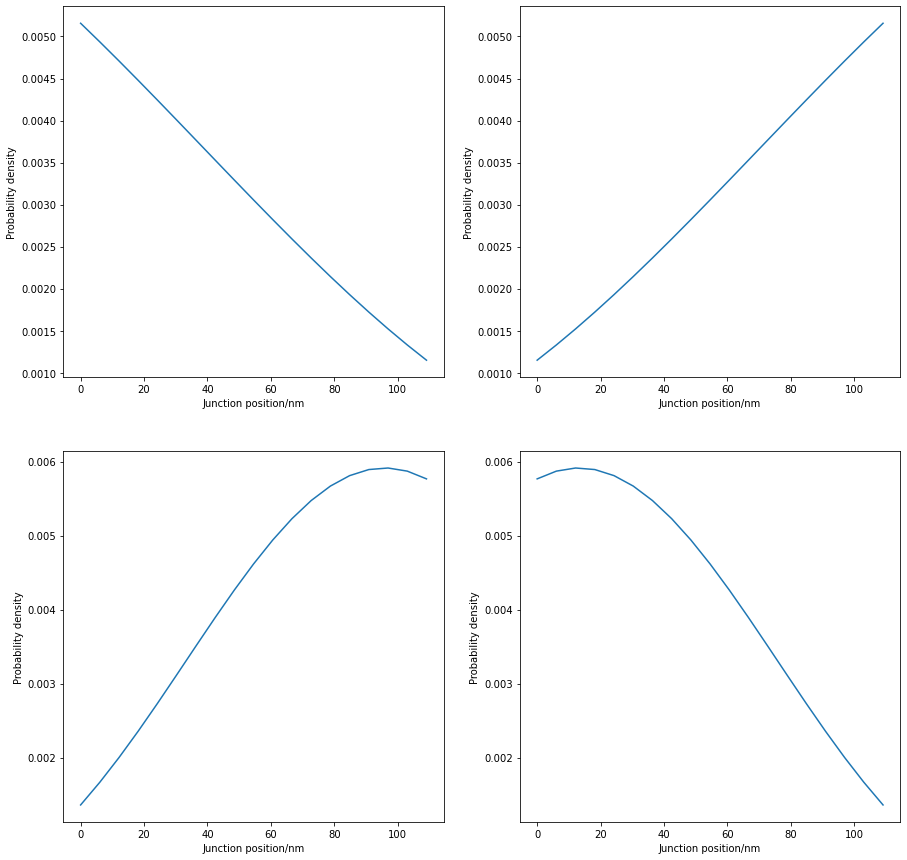

In [85]:
wavefunc_visualiser(psi_alpha_0, 0)
plt.savefig('./Istas testing/istas_ver', dpi=300)

In [86]:
def wavefunc_phase_visual(psi, index, a=60.583):
    wavefunc = psi[:, index]
    wavefunc = wavefunc*np.exp(-1j*np.angle(wavefunc[0]))
    print(np.around(np.angle(wavefunc), 2))
    plt.plot(np.arange(len(wavefunc)), np.around(np.angle(wavefunc), 2)%3.14)
    plt.xlabel('orbital indices')
    plt.ylabel('relative phase')

[-0.   -0.    3.14 -0.    0.    0.    3.14 -0.    0.    0.    3.14 -0.
  0.    0.    3.14 -0.    0.    0.    3.14 -0.    0.    0.    3.14 -0.
  0.    0.    3.14 -0.    0.    0.    3.14 -0.    0.    0.   -3.14 -0.
  0.    0.   -3.14  0.    0.    0.   -3.14  0.    0.    0.   -3.14  0.
  0.    0.   -3.14  0.    0.    0.   -3.14  0.    0.    0.   -3.14  0.
  0.    0.   -3.14  0.    0.    0.   -3.14  0.   -0.    0.   -3.14  0.
 -0.    0.   -3.14  0.  ]


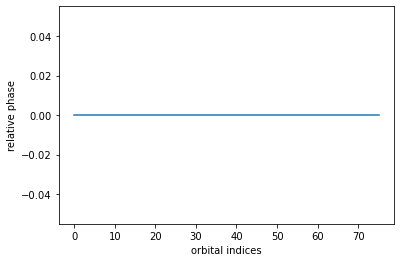

In [87]:
wavefunc_phase_visual(psi_alpha_0, 0)